In [27]:
import numpy as np
import matplotlib.pylab as plt
import time
from copy import deepcopy

import importlib
import matplotlib as mpl
import matplotlib.patches as mp
import pandas as pd
import torch
import matplotlib.patheffects as pe


from pyloric import create_prior, simulate, summary_stats
from stg_energy.common import col, svg, get_labels_8pt
import stg_energy.fig2_inference.viz as viz
from sbi.analysis import pairplot

# Figure 1

In [28]:
pd.options.display.max_columns=999

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
PANEL_A1 = '../svg/panel_a_no_noise1.svg'
PANEL_A2 = '../svg/panel_a_no_noise2.svg'
PANEL_A3 = '../svg/panel_a_no_noise3.svg'
PANEL_A4 = '../svg/panel_e_no_noise4.svg'

PANEL_B1 = '../svg/panel_b_no_noise1.svg'
PANEL_B2 = '../svg/panel_b_no_noise2.svg'
PANEL_B3 = '../svg/panel_b_no_noise3.svg'
PANEL_B4 = '../svg/panel_b_no_noise4.svg'

In [31]:
x_std = torch.as_tensor(
    [
        10,
        5,
        5,
        5,
        0.005,
        0.005,
        0.005,
        0.005,
        0.005,
        5,
        5,
        5,
        5,
        0.005,
        0.005,
        0.1,
        0.1,
        0.1,
    ]
)

### Select the simulations that were close

In [32]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster"
theta_internal_yes_observation_no = pd.read_pickle(path + '/simulate_11deg_R3_predictives_at_11deg/data/all_circuit_parameters.pkl')
all_x_internal_yes_observation_no = pd.read_pickle(path + '/simulate_11deg_R3_predictives_at_11deg/data/valid_simulation_outputs.pkl')
x_internal_yes_observation_no = pd.read_pickle(path + '/close_to_xo_simulation_outputs.pkl')
theta_np_internal_yes_observation_no = theta_internal_yes_observation_no.to_numpy()
x_np_internal_yes_observation_no = x_internal_yes_observation_no.to_numpy()
print("theta.to_numpy().shape", x_np_internal_yes_observation_no.shape)

theta.to_numpy().shape (35939, 34)


In [33]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster_no_noise"
theta_internal_no_observation_yes = pd.read_pickle(path + '/simulate_11deg_R3_predictives_at_11deg_obsnoise/data/all_circuit_parameters.pkl')
all_x_internal_no_observation_yes = pd.read_pickle(path + '/simulate_11deg_R3_predictives_at_11deg_obsnoise/data/valid_simulation_outputs.pkl')
noise = torch.randn(all_x_internal_no_observation_yes.to_numpy()[:, :18].shape) * x_std
all_x_internal_no_observation_yes = all_x_internal_no_observation_yes.iloc[:, :18].add(noise.numpy())

x_internal_no_observation_yes = pd.read_pickle(path + '/close_to_xo_simulation_outputs_obsnoise.pkl')
theta_np_internal_no_observation_yes = theta_internal_no_observation_yes.to_numpy()
x_np_internal_no_observation_yes = x_internal_no_observation_yes.to_numpy()
print("theta.to_numpy().shape", x_np_internal_no_observation_yes.shape)

theta.to_numpy().shape (69210, 34)


In [34]:
theta_internal_no_observation_yes

AB/PD                                                        \
                Na       CaT       CaS          A        KCa          Kd   
0       335.142822  3.642817  5.656654  52.437004  12.283934   86.156860   
1       404.451538  0.730120  2.389753  20.652334   2.207460  135.177536   
2       268.517273  5.971848  3.628879  56.184101   6.079761   55.622158   
3       221.978958  1.765614  3.796111  43.298199   8.913057  107.137741   
4       306.609863  3.152080  5.590533  20.147081  10.056272   51.646561   
...            ...       ...       ...        ...        ...         ...   
999995  250.889862  4.090577  6.781713  37.671867  13.389294  115.749344   
999996  146.205338  1.104031  4.095209  50.920265   5.619720  145.289093   
999997  425.476746  6.295744  5.525082  35.023663   8.144011   48.897888   
999998  317.351166  1.629837  5.113094  48.149223  11.404830   94.494820   
999999  365.962891  2.976633  3.530033  26.581545   7.830242   56.548164   

                                    LP                                 \
               H      Leak          Na       CaT       CaS          A   
0       0.009963  0.001948  166.358841  0.623696  7.492273  50.778019   
1       0.019322  0.003448   64.931961  1.811883  6.377604  57.964878   
2       0.010176  0.001251   91.985207  0.080190  5.885638  39.374813   
3       0.012730  0.002214   63.442348  0.478663  5.494138  34.548805   
4       0.001753  0.002591  173.545273  0.057237  8.355140  42.836842   
...          ...       ...         ...       ...       ...        ...   
999995  0.011923  0.008595  117.132713  2.005118  3.524361  34.405788   
999996  0.019679  0.003888   71.092064  1.716244  6.707365  46.281044   
999997  0.000343  0.001857  135.394577  0.253768  9.494118  56.105537   
999998  0.007105  0.001597  189.452042  1.890340  4.464040  35.285332   
999999  0.004595  0.008277  119.943466  1.647137  5.025185  53.272217   

                                                          PY             \
             KCa          Kd         H      Leak          Na        CaT   
0       5.582737   91.603127  0.046992  0.028519  413.623383  11.185506   
1       6.515990  117.265068  0.018158  0.015482  401.735321   5.629870   
2       1.718455   87.666817  0.011779  0.031467  302.195526   6.136609   
3       8.295957  117.138435  0.052248  0.039127  589.242676   6.865509   
4       7.401172  108.931053  0.045653  0.010372  500.586792   4.067754   
...          ...         ...       ...       ...         ...        ...   
999995  5.081974  104.726517  0.057372  0.026809  573.350891   7.251960   
999996  7.032457  114.102783  0.048553  0.028767  281.211731   9.522369   
999997  6.046223  113.660378  0.031347  0.038146  555.938782  11.436425   
999998  8.103642   91.564835  0.026546  0.027713   90.531898   5.526473   
999999  6.914482   53.835407  0.057278  0.015488  318.869873   7.105578   

                                                                       \
             CaS          A       KCa          Kd         H      Leak   
0       3.808970  37.492226  1.663072  103.034569  0.039658  0.004646   
1       3.399771  50.011951  2.260622  134.961380  0.021108  0.031057   
2       2.789069  51.078526  1.274477   80.756111  0.036761  0.007124   
3       2.017179  30.072115  0.725021  136.554352  0.032986  0.032368   
4       3.634317  35.931561  1.993152  136.231064  0.008874  0.007793   
...          ...        ...       ...         ...       ...       ...   
999995  1.973784  56.324017  1.681375  115.531067  0.058690  0.037008   
999996  3.151313  50.058983  2.588042   85.509819  0.057573  0.025928   
999997  2.550045  48.026382  3.035025  123.695892  0.027639  0.022607   
999998  1.835148  34.620880  0.496311  148.199875  0.038137  0.024112   
999999  2.651657  46.413567  1.542419   76.774902  0.010028  0.005664   

         Synapses                                                         \
            AB-LP      PD-LP      AB-PY      PD-PY      LP-PD      LP-PY

In [35]:
vals1 = np.std(theta_internal_no_observation_yes.to_numpy(), axis=0)

In [36]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster_no_noise"
theta_internal_yes_observation_yes = pd.read_pickle(path + '/simulate_11deg_R3_predictives_at_11deg_bothnoise/data/all_circuit_parameters.pkl')
all_x_internal_yes_observation_yes = pd.read_pickle(path + '/simulate_11deg_R3_predictives_at_11deg_bothnoise/data/valid_simulation_outputs.pkl')
noise = torch.randn(all_x_internal_yes_observation_yes.to_numpy()[:, :18].shape) * x_std
all_x_internal_yes_observation_yes = all_x_internal_yes_observation_yes.iloc[:, :18].add(noise.numpy())

x_internal_yes_observation_yes = pd.read_pickle(path + '/close_to_xo_simulation_outputs_bothnoise.pkl')
theta_np_internal_yes_observation_yes = theta_internal_yes_observation_yes.to_numpy()
x_np_internal_yes_observation_yes = x_internal_yes_observation_yes.to_numpy()
print("theta.to_numpy().shape", x_np_internal_yes_observation_yes.shape)

theta.to_numpy().shape (40236, 34)


In [37]:
vals2 = np.std(theta_internal_yes_observation_yes.to_numpy(), axis=0)

In [38]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster_no_noise"
theta_internal_no_observation_no = pd.read_pickle(path + '/simulate_11deg_R3_predictives_at_11deg/data/all_circuit_parameters.pkl')
all_x_internal_no_observation_no = pd.read_pickle(path + '/simulate_11deg_R3_predictives_at_11deg/data/valid_simulation_outputs.pkl')
x_internal_no_observation_no = pd.read_pickle(path + '/close_to_xo_simulation_outputs.pkl')
theta_np_internal_no_observation_no = theta_internal_no_observation_no.to_numpy()
x_np_internal_no_observation_no = x_internal_no_observation_no.to_numpy()
print("theta.to_numpy().shape", x_np_internal_no_observation_no.shape)

theta.to_numpy().shape (87937, 34)


In [39]:
x_o = np.load("../../../results/experimental_data/xo_11deg.npy", allow_pickle=True)

# Compute distances

In [40]:
path = "../../../results/simulation_data_Tube_MLslurm_cluster/01_simulate_11deg"
x_prior = pd.read_pickle(path + "/data/valid_simulation_outputs.pkl")
x_prior_np = x_prior.to_numpy()

stats_std = np.std(x_prior_np, axis=0)[:18]

In [41]:
distance_yes_no = np.mean(np.sqrt(np.sum((all_x_internal_yes_observation_no.to_numpy()[:,:18] - x_o)**2 / stats_std, axis=1)))
distance_no_yes = np.mean(np.sqrt(np.sum((all_x_internal_no_observation_yes.to_numpy()[:,:18]  - x_o)**2 / stats_std, axis=1)))
distance_yes_yes = np.mean(np.sqrt(np.sum((all_x_internal_yes_observation_yes.to_numpy()[:,:18]  - x_o)**2 / stats_std, axis=1)))
distance_no_no = np.mean(np.sqrt(np.sum((all_x_internal_no_observation_no.to_numpy()[:,:18]  - x_o)**2 / stats_std, axis=1)))

In [42]:
print(distance_yes_no)

3.3489329433002957


In [43]:
print(distance_no_yes)

3.0127602532438575


In [44]:
print(distance_yes_yes)

3.2691700309859826


In [45]:
print(distance_no_no)

2.5996921844247423


In [46]:
prior = create_prior(as_torch_dist=True)
lower_bound = prior.support.base_constraint.lower_bound
upper_bound = prior.support.base_constraint.upper_bound
prior_pd = create_prior()
lims = np.asarray([lower_bound.numpy(), upper_bound.numpy()]).T

### Load posteriors to compute DKL

In [55]:
import pickle

In [56]:
with open("../../../results/trained_neural_nets/inference/posterior_11deg_no_noise_bothnoise.pickle", "rb") as handle:
    posterior_broad = pickle.load(handle)

In [57]:
with open("../../../results/trained_neural_nets/inference/posterior_11deg_no_noise_obsnoise.pickle", "rb") as handle:
    posterior_obs = pickle.load(handle)

In [95]:
_ = torch.manual_seed(0)
num_samples = 100_000

In [96]:
broad_dist = posterior_broad.set_default_x(x_o)
narrow_dist = posterior_obs.set_default_x(x_o)

In [97]:
# broad_dist = torch.distributions.MultivariateNormal(torch.zeros(31), torch.eye(31))
# narrow_dist = torch.distributions.MultivariateNormal(torch.zeros(31), 0.8*torch.eye(31))

In [98]:
samples_both = broad_dist.sample((num_samples,))
log_probs_both = broad_dist.log_prob(samples_both)
log_probs_obs = narrow_dist.log_prob(samples_both)
dkl1 = torch.mean(log_probs_both - log_probs_obs)
print("dkl1", dkl1)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

dkl1 tensor(6.4218)


In [99]:
samples_obs = narrow_dist.sample((num_samples,))
log_probs_both = broad_dist.log_prob(samples_obs)
log_probs_obs = narrow_dist.log_prob(samples_obs)
dkl2 = torch.mean(log_probs_obs - log_probs_both)
print("dkl2", dkl2)

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

dkl2 tensor(5.2204)


# Panel A: posteriors

In [18]:
labels_ = get_labels_8pt()
labels_[9] += ''

/home/michael/Documents/STG_energy_sbi/sbi/utils/plot.py:563: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


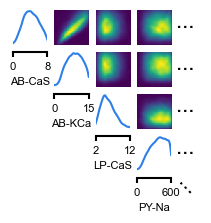

In [19]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, axes = pairplot(samples=[theta_np_internal_yes_observation_no[:10000]],
                           subset=[2,4,10, 16],
                           limits=lims,
                           ticks=lims,
                           figsize=(17.0*0.12, 17.0*0.12),
                           labels=labels_,
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           samples_colors=[col['SNPE']],
                           diag=['kde'],
                           upper=['kde'],
                           hist_offdiag={'bins':50},
                           plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]})

    plt.savefig(PANEL_A1, facecolor='None', transparent=True)
    plt.show()

/home/michael/Documents/STG_energy_sbi/sbi/utils/plot.py:563: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


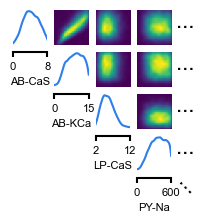

In [20]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, axes = pairplot(samples=[theta_np_internal_no_observation_yes[:10000]],
                           subset=[2,4,10, 16],
                           limits=lims,
                           ticks=lims,
                           figsize=(17.0*0.12, 17.0*0.12),
                           labels=labels_,
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           samples_colors=[col['SNPE']],
                           diag=['kde'],
                           upper=['kde'],
                           hist_offdiag={'bins':50},
                           plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]})

    plt.savefig(PANEL_A2, facecolor='None', transparent=True)
    plt.show()

/home/michael/Documents/STG_energy_sbi/sbi/utils/plot.py:563: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


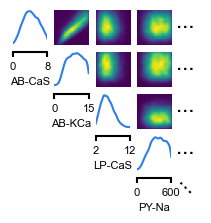

In [21]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, axes = pairplot(samples=[theta_np_internal_no_observation_no[:10000]],
                           subset=[2,4,10, 16],
                           limits=lims,
                           ticks=lims,
                           figsize=(17.0*0.12, 17.0*0.12),
                           labels=labels_,
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           samples_colors=[col['SNPE']],
                           diag=['kde'],
                           upper=['kde'],
                           hist_offdiag={'bins':50},
                           plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]})

    plt.savefig(PANEL_A3, facecolor='None', transparent=True)
    plt.show()

/home/michael/Documents/STG_energy_sbi/sbi/utils/plot.py:563: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:


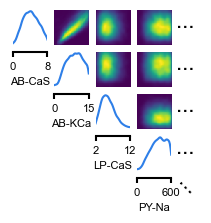

In [22]:
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, axes = pairplot(samples=[theta_np_internal_yes_observation_yes[:10000]],
                           subset=[2,4,10, 16],
                           limits=lims,
                           ticks=lims,
                           figsize=(17.0*0.12, 17.0*0.12),
                           labels=labels_,
                           scatter_offdiag={'rasterized':True, 'alpha':1.0},
                           samples_colors=[col['SNPE']],
                           diag=['kde'],
                           upper=['kde'],
                           hist_offdiag={'bins':50},
                           plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]})

    plt.savefig(PANEL_A4, facecolor='None', transparent=True)
    plt.show()

# Histograms

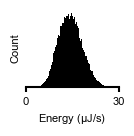

In [23]:
all_energies_per_spike = x_internal_yes_observation_no["energies_per_spike"].to_numpy()
all_total_energies = x_internal_yes_observation_no["energies"].to_numpy()

summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 1))

    _ = ax.hist(summed_energies_total/10/1000, range=[0, 30], bins=100, color="k")
    # ax[3].set_ylabel('Count')
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])

    plt.subplots_adjust(wspace=0.3)

    ax.set_xlim([0, 30])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_xticks([0, 30])
    ax.set_ylabel("Count")

    plt.savefig(PANEL_B1, facecolor="None", transparent=True)
    plt.show()

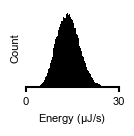

In [24]:
all_energies_per_spike = x_internal_no_observation_yes["energies_per_spike"].to_numpy()
all_total_energies = x_internal_no_observation_yes["energies"].to_numpy()

summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 1))

    _ = ax.hist(summed_energies_total/10/1000, range=[0, 30], bins=100, color="k")
    # ax[3].set_ylabel('Count')
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])

    plt.subplots_adjust(wspace=0.3)

    ax.set_xlim([0, 30])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_xticks([0, 30])
    ax.set_ylabel("Count")

    plt.savefig(PANEL_B2, facecolor="None", transparent=True)
    plt.show()

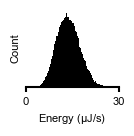

In [25]:
all_energies_per_spike = x_internal_no_observation_no["energies_per_spike"].to_numpy()
all_total_energies = x_internal_no_observation_no["energies"].to_numpy()

summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 1))

    _ = ax.hist(summed_energies_total/10/1000, range=[0, 30], bins=100, color="k")
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])

    plt.subplots_adjust(wspace=0.3)

    ax.set_xlim([0, 30])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_xticks([0, 30])
    ax.set_ylabel("Count")

    plt.savefig(PANEL_B3, facecolor="None", transparent=True)
    plt.show()

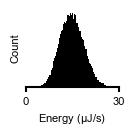

In [26]:
all_energies_per_spike = x_internal_yes_observation_yes["energies_per_spike"].to_numpy()
all_total_energies = x_internal_yes_observation_yes["energies"].to_numpy()

summed_energies_per_spike = np.sum(np.asarray(all_energies_per_spike), axis=1)
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(1.2, 1))

    _ = ax.hist(summed_energies_total/10/1000, range=[0, 30], bins=100, color="k")
    # ax[3].set_ylabel('Count')
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])

    plt.subplots_adjust(wspace=0.3)

    ax.set_xlim([0, 30])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_xticks([0, 30])
    ax.set_ylabel("Count")

    plt.savefig(PANEL_B4, facecolor="None", transparent=True)
    plt.show()

# Assemble figure

In [27]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [31]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}


sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "8.3cm",
    
    Panel(
          SVG(PANEL_A1).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("a", -10.5*factor_svg, 1.5*factor_svg-dshift, **kwargs_text),
          Text("Only intrinsic noise", -2.8*factor_svg, 0.8*factor_svg, **kwargs_text8pt),
    ).move(10.5*factor_svg, 1.3*factor_svg),
    
    Panel(
          SVG(PANEL_A2).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("Only observation noise", -4*factor_svg, 0.8*factor_svg, **kwargs_text8pt),
    ).move(45.5*factor_svg, 1.3*factor_svg),
           
#     Panel(
#           SVG(PANEL_A3).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
#           Text("No noise", 1.5*factor_svg, 0.8*factor_svg, **kwargs_text8pt),
#     ).move(80.5*factor_svg, 1.3*factor_svg),
    
    Panel(
          SVG(PANEL_A4).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("Intrinsic & observation noise", -6.2*factor_svg, 0.8*factor_svg, **kwargs_text8pt),
    ).move(80.5*factor_svg, 1.3*factor_svg),
           
    Panel(
          SVG(PANEL_B1).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("b", -14.5*factor_svg, 1.5*factor_svg-dshift, **kwargs_text),
    ).move(14.5*factor_svg, 36.3*factor_svg),
    
    Panel(
          SVG(PANEL_B2).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
    ).move(49.5*factor_svg, 36.3*factor_svg),
    
#     Panel(
#           SVG(PANEL_B3).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
#     ).move(84.5*factor_svg, 36.3*factor_svg),
    
    Panel(
          SVG(PANEL_B4).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
    ).move(84.5*factor_svg, 36.3*factor_svg),
)

!mkdir -p fig
f.save("../fig/fig2_no_noise.svg")
svg('../fig/fig2_no_noise.svg')